# Preprocessing

In [36]:
import pandas as pd

# Load initial data
df_mut = pd.read_csv('/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/raw/TCGA.BRCA.mutations.txt', sep='\t')
initial_count = len(df_mut)
print(f"Initial rows loaded: {initial_count:,}")

# --- Step 1: Filter 'PASS' ---
count_before = len(df_mut)

df_mut = df_mut[df_mut['FILTER'] == 'PASS'] # exclude samples the didn't pass QC

count_after = len(df_mut)
print(f"Filtered out {count_before - count_after:,} rows (FILTER != 'PASS'). Remaining: {count_after:,}")


# --- Step 2: Filter 'SNP' ---
count_before = len(df_mut)

df_mut = df_mut[df_mut['Variant_Type'] == 'SNP'] # exclude indels

count_after = len(df_mut)
print(f"Filtered out {count_before - count_after:,} rows (Variant_Type != 'SNP'). Remaining: {count_after:,}")


# --- Step 3: Calculate 'mutation_type' ---
print("Determining synonymous or nonsynonymous mutations...")
df_mut.loc[:,'mutation_type'] = df_mut.apply(lambda row: 'synonymous' if row['Variant_Classification'] == 'Silent' else 'non-synonymous' if row['CDS_position'] != '.' else None, axis=1)


# --- Step 4: Drop rows where 'mutation_type' is None ---
print("Filtering out mutations not in CDS...")
count_before = len(df_mut)

df_mut = df_mut.dropna(subset=['mutation_type']) # Drop rows that have None (or NaN) in the 'mutation_type' column

count_after = len(df_mut)
print(f"Filtered out {count_before - count_after:,} rows (mutation_type is None). Remaining: {count_after:,}")


# --- Step 5: Filter Hugo_Symbol NA ---
count_before = len(df_mut)

df_mut = df_mut[df_mut['Hugo_Symbol'].notna()] # remove genes that don't have a symbol

count_after = len(df_mut)
print(f"Filtered out {count_before - count_after:,} rows (Hugo_Symbol is NA). Remaining: {count_after:,}")


# --- Step 6: Filter Start_Position NA ---
count_before = len(df_mut)

df_mut = df_mut[df_mut['Start_Position'].notna()] # remove rows without a position

count_after = len(df_mut)
print(f"Filtered out {count_before - count_after:,} rows (Start_Position is NA). Remaining: {count_after:,}")


# --- Step 7: Filter Hypermutators ---
print("Filtering hypermutator samples (>500 mutations/patient)...")

mutation_counts = df_mut['patient_id'].value_counts() # count mutations per patient

# Identify patients with <= 500 mutations
hypermutator_threshold = 500
normal_mutators = mutation_counts[mutation_counts <= hypermutator_threshold].index
hypermutator_patients = mutation_counts[mutation_counts > hypermutator_threshold].index
print(f" -> Identified {len(hypermutator_patients):,} hypermutator patients.")

count_before = len(df_mut)

df_mut = df_mut[df_mut['patient_id'].isin(normal_mutators)] # filter out hypermutators

count_after = len(df_mut)
print(f"Filtered out {count_before - count_after:,} rows belonging to hypermutators. Remaining: {count_after:,}")


# --- Final Count ---
print(f"\nFinal number of rows after all filters: {len(df_mut):,}")

Initial rows loaded: 134,947
Filtered out 42,911 rows (FILTER != 'PASS'). Remaining: 92,036
Filtered out 11,044 rows (Variant_Type != 'SNP'). Remaining: 80,992
Determining synonymous or nonsynonymous mutations...
Filtering out mutations not in CDS...
Filtered out 14,512 rows (mutation_type is None). Remaining: 66,480
Filtered out 0 rows (Hugo_Symbol is NA). Remaining: 66,480
Filtered out 0 rows (Start_Position is NA). Remaining: 66,480
Filtering hypermutator samples (>500 mutations/patient)...
 -> Identified 16 hypermutator patients.
Filtered out 18,484 rows belonging to hypermutators. Remaining: 47,996

Final number of rows after all filters: 47,996


In [37]:
df_mut

,patient_id,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,...,PolyPhen,DOMAINS,IMPACT,VARIANT_CLASS,FILTER,COSMIC,CALLERS,CONTEXT,NCALLERS,mutation_type
3,TCGA-3C-AAAU,CD248,0,.,GRCh37,11,66082467,66082467,+,Missense_Mutation,...,benign(0.001),"Low_complexity_(Seg):seg,hmmpanther:PTHR24838:...",MODERATE,SNV,PASS,NONE,MUTECT|VARSCANS,GTGCTCGGCAA,2,non-synonymous
7,TCGA-3C-AAAU,MIPOL1,0,.,GRCh37,14,37838785,37838785,+,Missense_Mutation,...,benign(0.002),"Coiled-coils_(Ncoils):Coil,hmmpanther:PTHR22089",MODERATE,SNV,PASS,NONE,SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS,ACAACATGAGA,5,non-synonymous
8,TCGA-3C-AAAU,THSD4,0,.,GRCh37,15,72039337,72039337,+,Missense_Mutation,...,benign(0.444),"PROSITE_profiles:PS50092,hmmpanther:PTHR13723,...",MODERATE,SNV,PASS,NONE,SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS,GCCAACTCAAG,5,non-synonymous
9,TCGA-3C-AAAU,ULK3,0,.,GRCh37,15,75130677,75130677,+,Silent,...,.,"Low_complexity_(Seg):seg,hmmpanther:PTHR24348,...",LOW,SNV,PASS,NONE,SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS,CCGGCGGCCTC,5,synonymous
10,TCGA-3C-AAAU,CACNA1H,0,.,GRCh37,16,1260133,1260133,+,Silent,...,.,"hmmpanther:PTHR10037,hmmpanther:PTHR10037:SF192",LOW,SNV,PASS,NONE,SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS,CAGAACCGGTG,5,synonymous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134937,TCGA-Z7-A8R6,KCNT1,0,.,GRCh37,9,138660705,138660705,+,Missense_Mutation,...,probably_damaging(0.97),"Gene3D:3.40.50.720,hmmpanther:PTHR10027,hmmpan...",MODERATE,SNV,PASS,NONE,MUTECT|RADIA|SOMATICSNIPER|MUSE|VARSCANS,GGGCCGTGAAG,5,non-synonymous
134938,TCGA-Z7-A8R6,RABL6,0,.,GRCh37,9,139732034,139732034,+,Missense_Mutation,...,benign(0.002),"Low_complexity_(Seg):seg,hmmpanther:PTHR14932",MODERATE,SNV,PASS,NONE,SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS,CCCCTCAGCCC,5,non-synonymous
134940,TCGA-Z7-A8R6,PGM5,0,.,GRCh37,9,70993158,70993158,+,Missense_Mutation,...,probably_damaging(1),"hmmpanther:PTHR22573,hmmpanther:PTHR22573:SF27...",MODERATE,SNV,PASS,NONE,MUTECT|RADIA|SOMATICSNIPER|MUSE|VARSCANS,GACACCTGCGG,5,non-synonymous
134942,TCGA-Z7-A8R6,IPPK,0,.,GRCh37,9,95396703,95396703,+,Missense_Mutation,...,probably_damaging(0.968),"hmmpanther:PTHR14456,Pfam_domain:PF06090",MODERATE,SNV,PASS,NONE,RADIA|MUTECT|MUSE|VARSCANS,ATCCTCAGTGG,4,non-synonymous


In [62]:
df_mut.to_csv('/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/processed/TCGA.BRCA.mutations.qc1.txt', header=True, index=False, sep='\t')

In [63]:
df_mut = pd.read_csv('/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/processed/TCGA.BRCA.mutations.qc1.txt', sep='\t')
df_mut

,patient_id,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,...,PolyPhen,DOMAINS,IMPACT,VARIANT_CLASS,FILTER,COSMIC,CALLERS,CONTEXT,NCALLERS,mutation_type
0,TCGA-3C-AAAU,CD248,0,.,GRCh37,11,66082467,66082467,+,Missense_Mutation,...,benign(0.001),"Low_complexity_(Seg):seg,hmmpanther:PTHR24838:...",MODERATE,SNV,PASS,NONE,MUTECT|VARSCANS,GTGCTCGGCAA,2,non-synonymous
1,TCGA-3C-AAAU,MIPOL1,0,.,GRCh37,14,37838785,37838785,+,Missense_Mutation,...,benign(0.002),"Coiled-coils_(Ncoils):Coil,hmmpanther:PTHR22089",MODERATE,SNV,PASS,NONE,SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS,ACAACATGAGA,5,non-synonymous
2,TCGA-3C-AAAU,THSD4,0,.,GRCh37,15,72039337,72039337,+,Missense_Mutation,...,benign(0.444),"PROSITE_profiles:PS50092,hmmpanther:PTHR13723,...",MODERATE,SNV,PASS,NONE,SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS,GCCAACTCAAG,5,non-synonymous
3,TCGA-3C-AAAU,ULK3,0,.,GRCh37,15,75130677,75130677,+,Silent,...,.,"Low_complexity_(Seg):seg,hmmpanther:PTHR24348,...",LOW,SNV,PASS,NONE,SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS,CCGGCGGCCTC,5,synonymous
4,TCGA-3C-AAAU,CACNA1H,0,.,GRCh37,16,1260133,1260133,+,Silent,...,.,"hmmpanther:PTHR10037,hmmpanther:PTHR10037:SF192",LOW,SNV,PASS,NONE,SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS,CAGAACCGGTG,5,synonymous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47991,TCGA-Z7-A8R6,KCNT1,0,.,GRCh37,9,138660705,138660705,+,Missense_Mutation,...,probably_damaging(0.97),"Gene3D:3.40.50.720,hmmpanther:PTHR10027,hmmpan...",MODERATE,SNV,PASS,NONE,MUTECT|RADIA|SOMATICSNIPER|MUSE|VARSCANS,GGGCCGTGAAG,5,non-synonymous
47992,TCGA-Z7-A8R6,RABL6,0,.,GRCh37,9,139732034,139732034,+,Missense_Mutation,...,benign(0.002),"Low_complexity_(Seg):seg,hmmpanther:PTHR14932",MODERATE,SNV,PASS,NONE,SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS,CCCCTCAGCCC,5,non-synonymous
47993,TCGA-Z7-A8R6,PGM5,0,.,GRCh37,9,70993158,70993158,+,Missense_Mutation,...,probably_damaging(1),"hmmpanther:PTHR22573,hmmpanther:PTHR22573:SF27...",MODERATE,SNV,PASS,NONE,MUTECT|RADIA|SOMATICSNIPER|MUSE|VARSCANS,GACACCTGCGG,5,non-synonymous
47994,TCGA-Z7-A8R6,IPPK,0,.,GRCh37,9,95396703,95396703,+,Missense_Mutation,...,probably_damaging(0.968),"hmmpanther:PTHR14456,Pfam_domain:PF06090",MODERATE,SNV,PASS,NONE,RADIA|MUTECT|MUSE|VARSCANS,ATCCTCAGTGG,4,non-synonymous


# Top 20 Most Mutated Genes by Raw Count

Preparing data for stacked bar plot with detailed non-synonymous breakdown...
Generating stacked bar plot for top 30 genes...


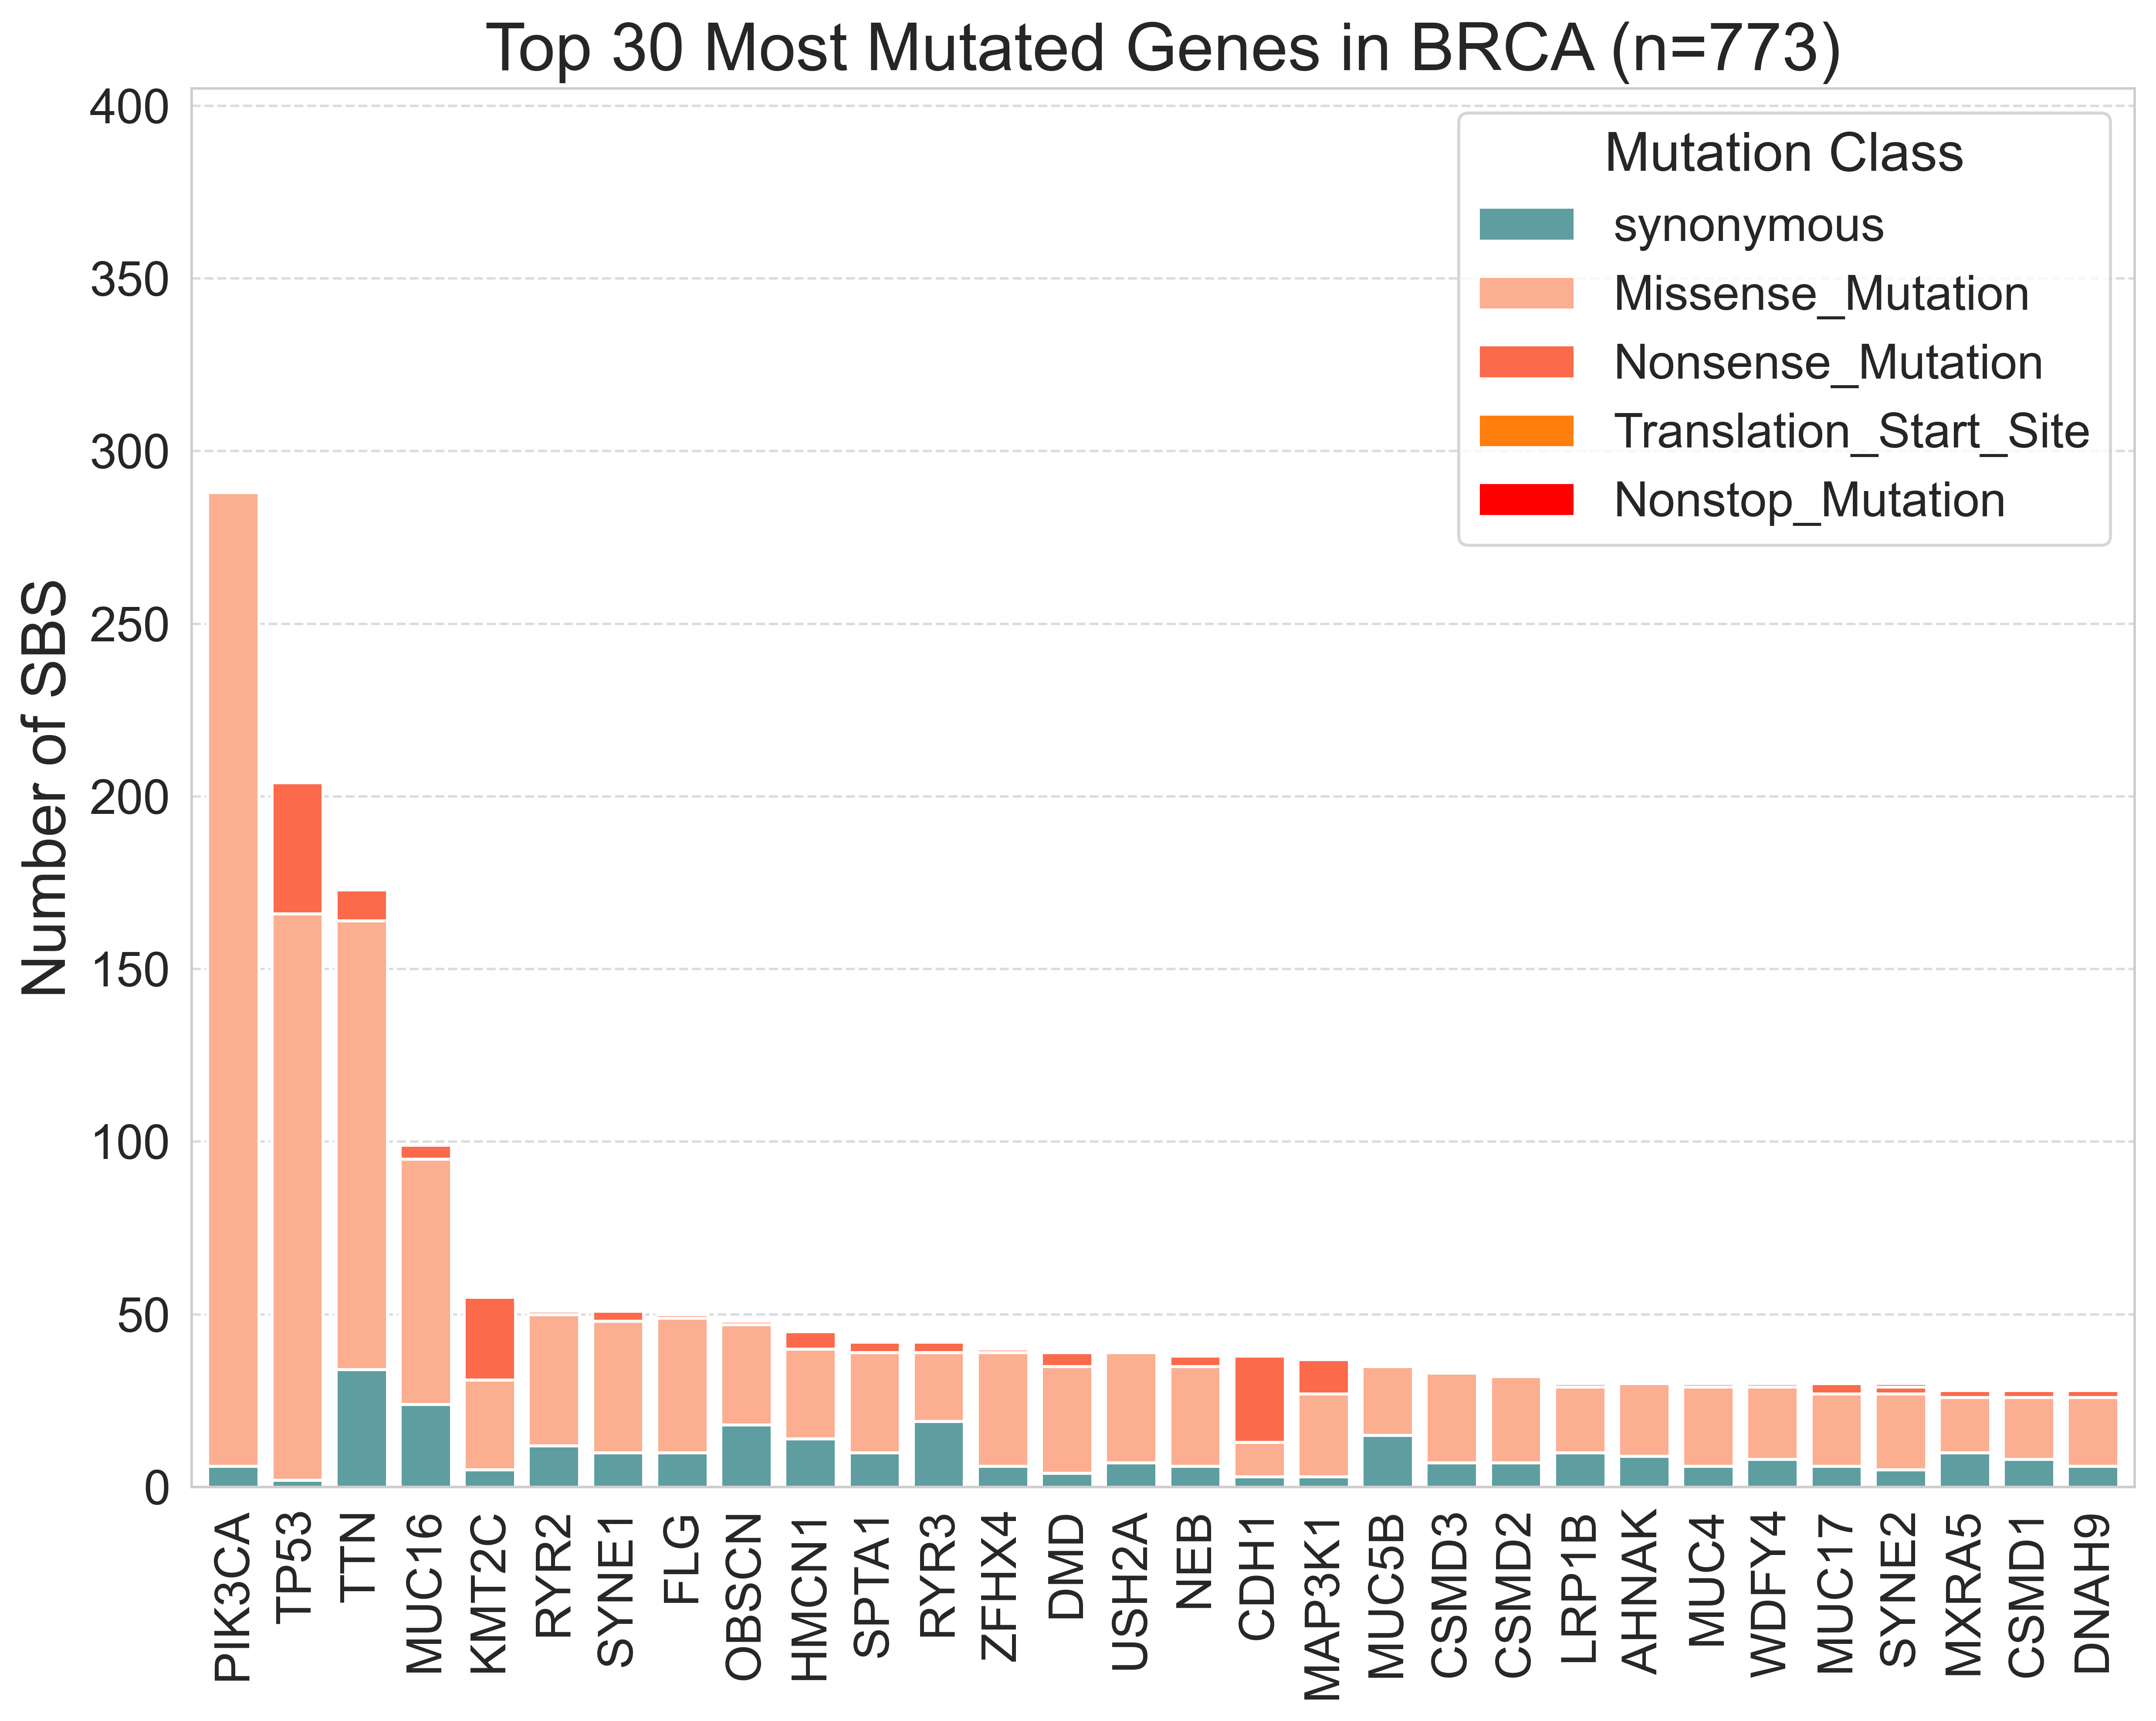

In [217]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Ensure df_mut DataFrame is loaded and processed correctly before this point ---
# Must contain 'Hugo_Symbol', 'mutation_type', and 'Variant_Classification'

print("Preparing data for stacked bar plot with detailed non-synonymous breakdown...")

# 1. Create a unified classification column
df_mut['mutation_class'] = df_mut.apply(
    lambda x: x['Variant_Classification']
              if x['mutation_type'] == 'non-synonymous'
              else 'synonymous',
    axis=1
)

# 2. Define the desired categories and their plot order
syn_col = 'synonymous'
non_syn_classes = [
    "Missense_Mutation",
    "Nonsense_Mutation",
    "Translation_Start_Site",
    "Nonstop_Mutation",
] #  and Nonstop_Mutation don't have recurrently mutated genes
all_classes = [syn_col] + non_syn_classes

# 3. Group and pivot to get counts per gene per class
mutation_counts = df_mut.groupby(['Hugo_Symbol', 'mutation_class']).size()
counts_df = mutation_counts.unstack(fill_value=0)

# 4. Ensure all columns exist
for col in all_classes:
    if col not in counts_df.columns:
        counts_df[col] = 0

# 5. Reorder columns
counts_df = counts_df[all_classes]

# 6. Optional: select top N genes by total mutations
counts_df['TotalMutations'] = counts_df.sum(axis=1)
N = 30
top_n = counts_df.sort_values('TotalMutations', ascending=False).head(N)
plot_df = top_n.drop(columns='TotalMutations')

# 7. Define a color palette: one blue for synonymous, shades of red for non-synonymous
palette = [
    'cadetblue',      # synonymous
    '#fcae91',        # Missense_Mutation (light red) 
    '#fb6a4a',        # Nonsense_Mutation
    "tab:orange",  # Translation_Start_Site
    "red",  # Nonstop_Mutation
]

# 8. Plot
if plot_df.empty:
    print("No data available to plot.")
else:
    print(f"Generating stacked bar plot for top {N} genes...")
    fig, ax = plt.subplots(
        figsize=(max(10, len(plot_df) * 0.3), 8),
        dpi=500
    )

    # Plot on this axis
    plot_df.plot(
        kind='bar',
        stacked=True,
        width=0.8,
        color=palette,
        ax=ax
    )

    # Labels and styling
    ax.set_title(f'Top {N} Most Mutated Genes in BRCA (n=773)', fontsize=22)
    ax.set_xlabel('', fontsize=20)
    ax.set_ylabel('Number of SBS', fontsize=20)
    ax.set_xticklabels(plot_df.index, rotation=90, fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.legend(title='Mutation Class', fontsize=16, title_fontsize=18)
    ax.grid(False)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, 405)

    plt.tight_layout()

    # Save at high resolution
    fig.savefig(
        "/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/results/figures/Most_mutated_genes_detailed.pdf",
        format="pdf",
        bbox_inches="tight",
        dpi=500
    )

    plt.show()

# Compare to [IntOGen](https://www.intogen.org/search?cohort=TCGA_WXS_BRCA) BRCA TCGA WES from 1009 samples

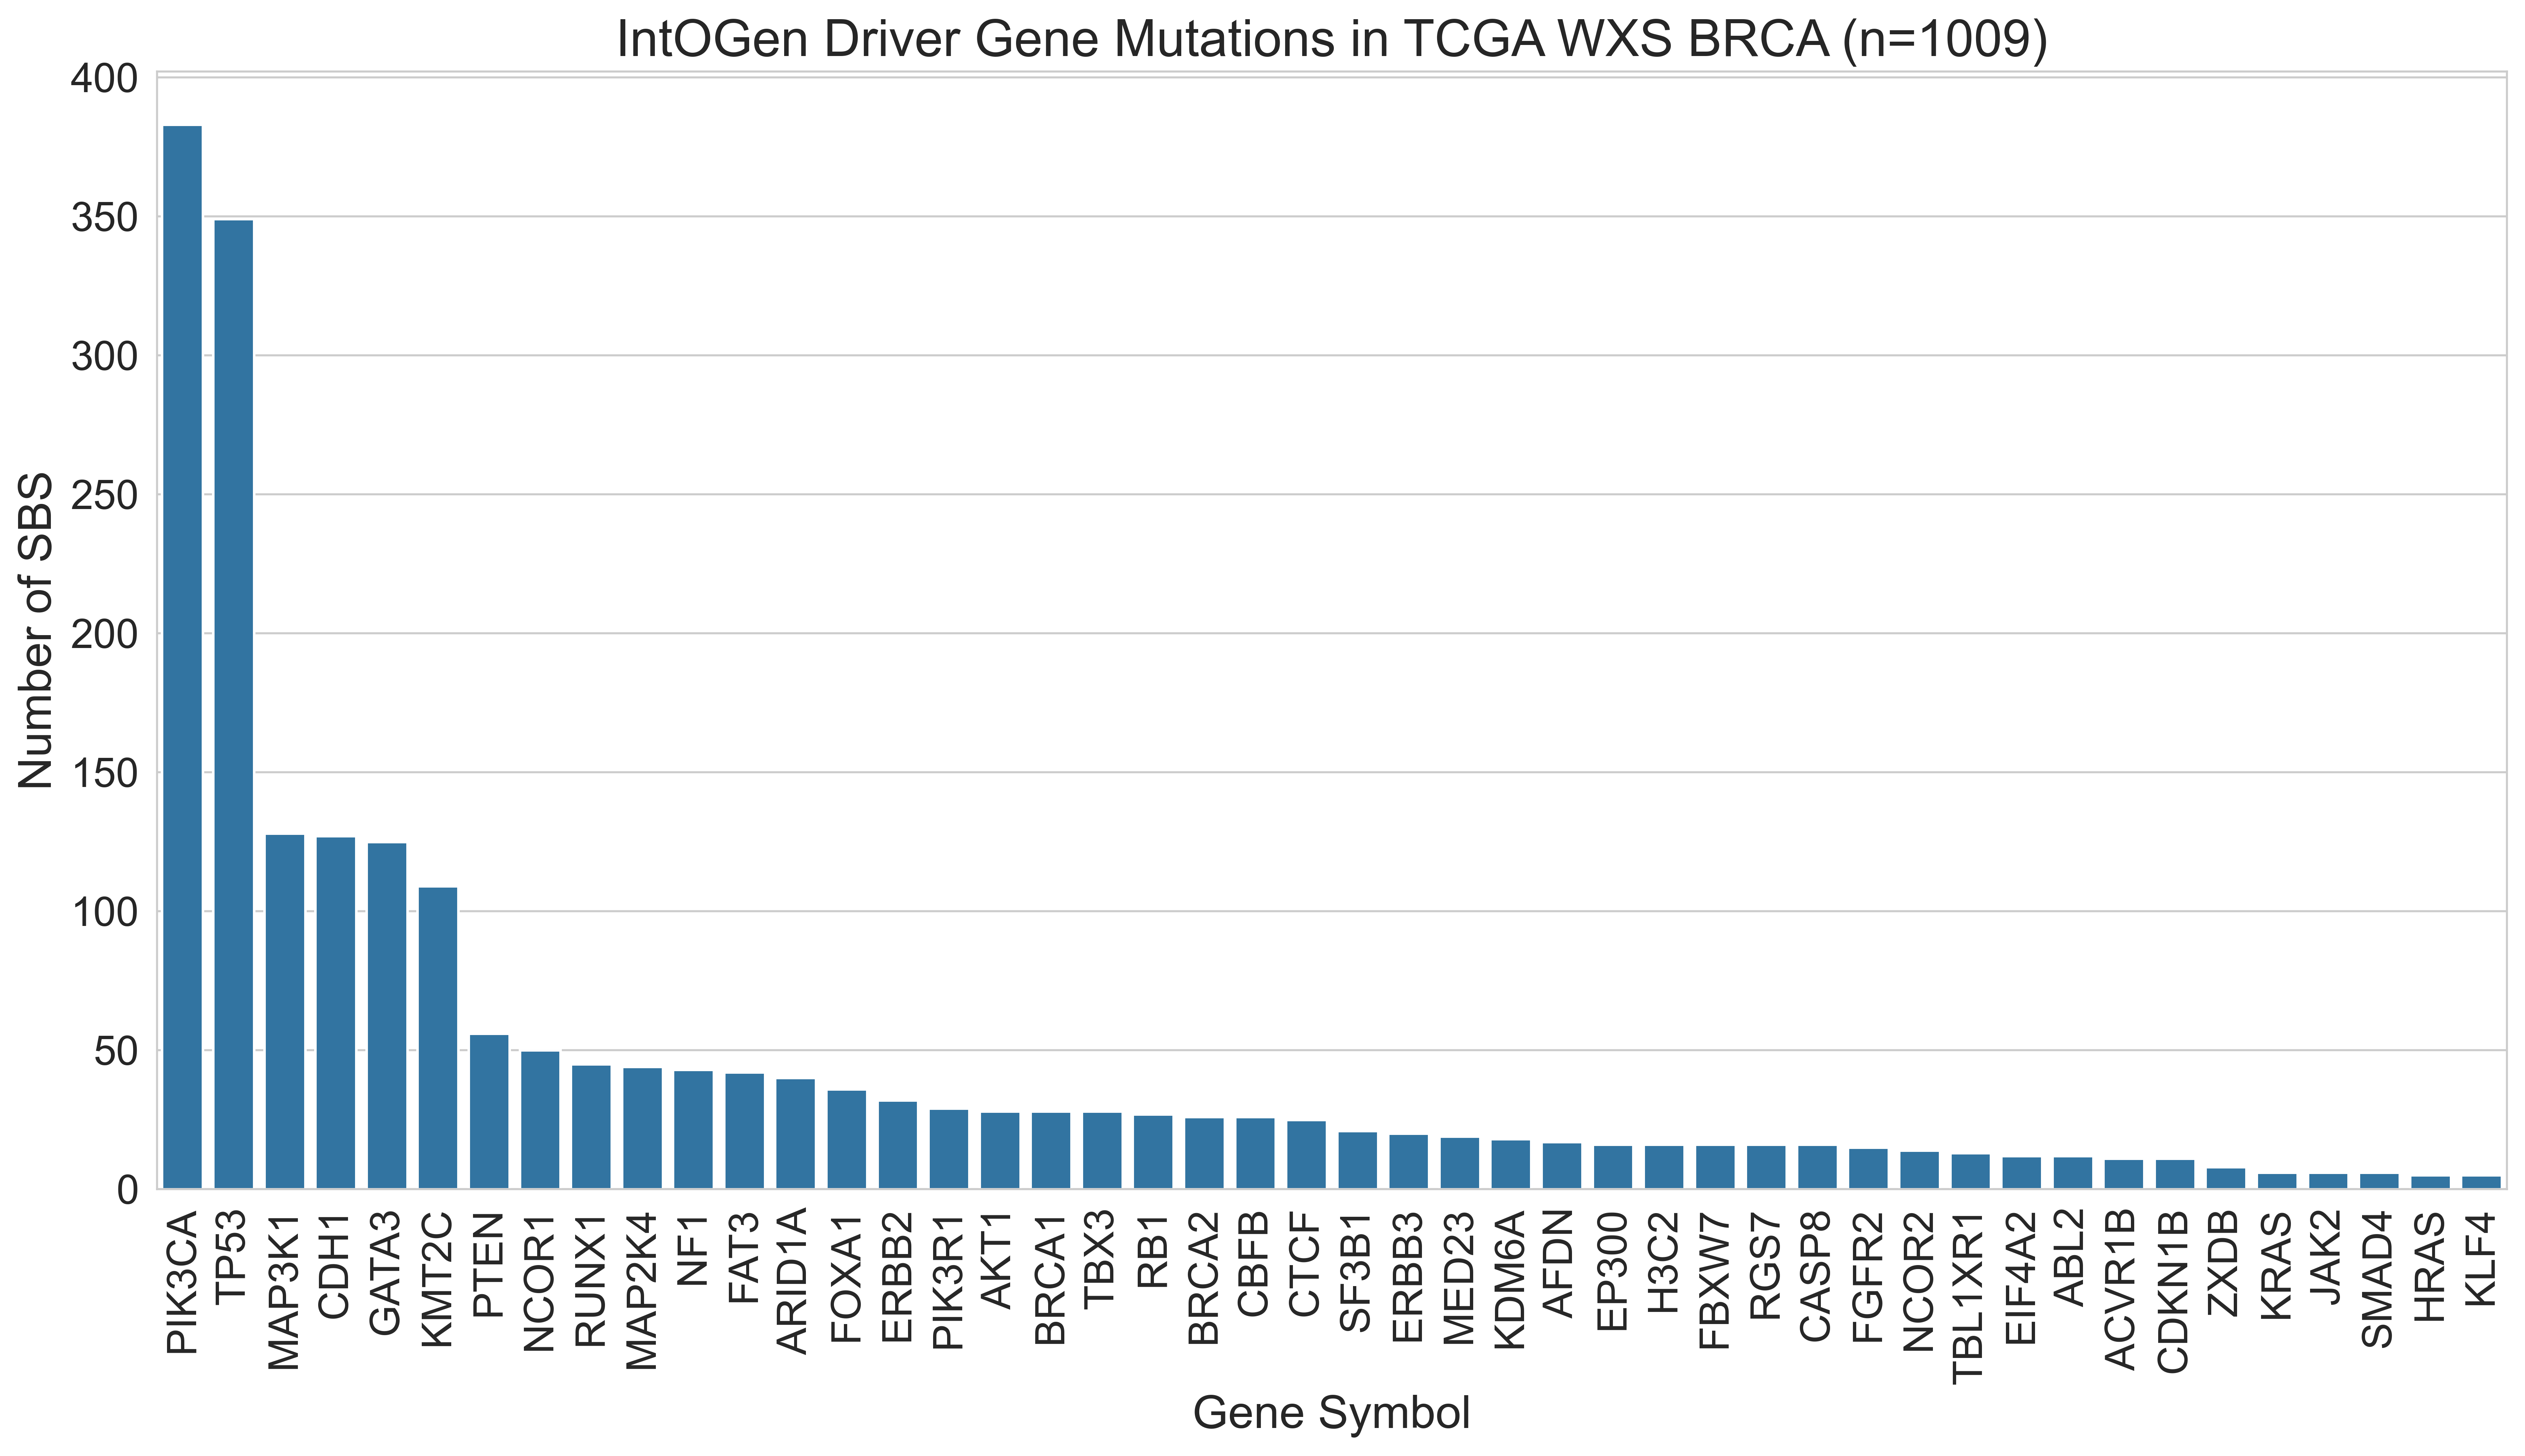

In [215]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load IntOGen data
IntOGen = '/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/processed/IntOGen-DriverGenes_TCGA_WXS_BRCA.csv'
df_intogen = pd.read_csv(IntOGen, dtype={'Symbol': str, 'Mutations': int})

# 2. Sort by number of mutations (descending)
df_intogen_sorted = df_intogen.sort_values('Mutations', ascending=False)

# 3. Plot barplot with tab:blue color
plt.figure(figsize=(max(10, len(df_intogen_sorted) * 0.3), 8), dpi=500)
sns.barplot(
    data=df_intogen_sorted,
    x='Symbol',
    y='Mutations',
    color='tab:blue'
)

# 4. Customize plot
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Gene Symbol', fontsize=18)
plt.ylabel('Number of SBS', fontsize=18)
plt.title('IntOGen Driver Gene Mutations in TCGA WXS BRCA (n=1009)', fontsize=20)
plt.tight_layout()

# 5. Save and show
output_path = "/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/results/figures/IntOGen_DriverGenes_BRCA_Mutations.pdf"
plt.savefig(output_path, format="pdf", bbox_inches="tight")
plt.show()

# Make CDS length table using Gencode fasta

In [ ]:
import pandas as pd
import re

# File paths
tsv_path = "/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/processed/TCGA.BRCA.mutations.qc1.txt"
fasta_in = "/Users/zichenjiang/Downloads/gencode.v23lift37.pc_transcripts.fa"
fasta_out = "/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/processed/gencode.v23lift37.pc_transcripts.transcripts_in_TCGA_MAF.fa"
CDS_length_table = "/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/processed/gencode.v23lift37.pc_transcripts.transcripts_in_TCGA_MAF.cds_lengths.tsv"

# 1. Read TSV into DataFrame and build mapping Transcript_ID -> Hugo_Symbol
tsv = pd.read_csv(tsv_path, sep="\t", dtype=str)
if "Transcript_ID" not in tsv.columns or "Hugo_Symbol" not in tsv.columns:
    raise RuntimeError("TSV must contain 'Transcript_ID' and 'Hugo_Symbol' columns")
mapping = dict(zip(tsv["Transcript_ID"], tsv["Hugo_Symbol"]))
ids = set(mapping.keys())

# 2. Iterate FASTA, filter entries, compute CDS length, and write filtered FASTA
results = []
with open(fasta_in, "r") as fin, open(fasta_out, "w") as fout:
    lines = iter(fin)
    for line in lines:
        if not line.startswith(">"):
            continue
        header = line.rstrip("\n")
        transcript_full = header[1:].split()[0]
        transcript = transcript_full.split(".")[0]
        if transcript in ids:
            # write header and sequence line
            fout.write(header + "\n")
            seq_line = next(lines, "")
            fout.write(seq_line)
            # extract CDS:start-end
            m = re.search(r"CDS:(\d+)-(\d+)", header)
            if m:
                start, end = map(int, m.groups())
                cds_length = end - start + 1
            else:
                cds_length = None
            # collect result
            results.append({
                "Hugo_Symbol": mapping[transcript],
                "Transcript_ID": transcript,
                "CDS_length": cds_length
            })

# 3. Build DataFrame, sort by Hugo_Symbol, and save to TSV
df = pd.DataFrame(results)
df_sorted = df.sort_values("Hugo_Symbol").reset_index(drop=True)
df_sorted.to_csv(CDS_length_table, index=False, sep="\t")

print(f"Filtered FASTA written to {fasta_out}")
print(f"CDS lengths saved to {CDS_length_table}")
print(f"CDS lengths saved to {CDS_length_table}")

Filtered FASTA written to /Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/processed/gencode.v23lift37.pc_transcripts.transcripts_in_TCGA_MAF.fa
CDS lengths saved to /Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/processed/gencode.v23lift37.pc_transcripts.transcripts_in_TCGA_MAF.cds_lengths.tsv


# Top 20 Most Mutated Genes (normalized by CDS length)

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Ensure df_mut DataFrame is loaded and processed correctly before this point ---
# Must contain 'Hugo_Symbol', 'mutation_type', and 'Variant_Classification'

# 0. Load gene sizes
sizes_path = "/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/processed/gencode.v23lift37.pc_transcripts.transcripts_in_TCGA_MAF.cds_lengths.tsv"
df_sizes = pd.read_csv(sizes_path, sep="\t", dtype={'Hugo_Symbol': str, 'CDS_length': int})

# Warn if any Hugo_Symbol appears more than once
dup_counts = df_sizes['Hugo_Symbol'].value_counts()
dups = dup_counts[dup_counts > 1].index.tolist()
if dups:
    print(f"Warning: multiple CDS_length entries found for genes: {dups}")

# Keep largest CDS size per gene
print(f"Keeping largest CDS size per gene...")
df_sizes = (
    df_sizes
    .sort_values('CDS_length', ascending=False)
    .drop_duplicates('Hugo_Symbol')
    .set_index('Hugo_Symbol')
)
df_sizes

Keeping largest CDS size per gene...


,Transcript_ID,CDS_length
Hugo_Symbol,,
TTN,ENST00000589042,107976
MUC16,ENST00000397910,43524
OBSCN,ENST00000570156,26772
SYNE1,ENST00000367255,26394
NEB,ENST00000397345,25578
...,...,...
TRGJP,ENST00000390338,61
TRAJ50,ENST00000390487,60
TRAJ21,ENST00000390516,55


In [171]:
# 1. Create a unified classification column
df_mut['mutation_class'] = df_mut.apply(
    lambda x: x['Variant_Classification']
              if x['mutation_type'] == 'non-synonymous'
              else 'synonymous',
    axis=1
)

# 2. Define categories and order
syn_col = 'synonymous'
non_syn_classes = ["Missense_Mutation", "Nonsense_Mutation", "Translation_Start_Site", "Nonstop_Mutation"]
all_classes = [syn_col] + non_syn_classes

# 3. Group and pivot to get counts per gene per class
mutation_counts = df_mut.groupby(['Hugo_Symbol', 'mutation_class']).size()
counts_df = mutation_counts.unstack(fill_value=0)

# 4. Ensure all classes exist
for col in all_classes:
    if col not in counts_df.columns:
        counts_df[col] = 0

# 5. Reorder columns
counts_df = counts_df[all_classes]

# 6. Filter genes with at least 5 total mutations
counts_df = counts_df[counts_df.sum(axis=1) >= 5]

# 7. Normalize by CDS length
counts_df = counts_df.join(df_sizes['CDS_length'], how='left')
counts_df


,synonymous,Missense_Mutation,Nonsense_Mutation,Translation_Start_Site,Nonstop_Mutation,CDS_length
Hugo_Symbol,,,,,,
A2M,1,4,2,0,0,4425.0
A2ML1,4,6,1,0,0,4365.0
AARS,1,4,0,0,0,2907.0
AATK,1,4,0,0,0,4125.0
ABCA1,2,3,0,0,0,6786.0
...,...,...,...,...,...,...
ZSCAN32,1,4,0,0,0,1458.0
ZSWIM4,1,4,0,0,0,2970.0
ZSWIM8,3,6,0,0,0,5529.0


### Normalize by length

TP53, PIK3CA, CBFB, PTEN, HIST1H2BC, AKT1, MAP2K4, HIST2H2BE, TRAV3, CDH1, FOXA1, NRK, GPR141, MYL12A, CRYGC, RUNX1, GATA3, MAGEA12, OR8K1, CASP8, MEA1, GINS4, HRAS, KRAS, MAGEB1, OR4M1, RAB9B, HMGN5, SYT16, MAP3K1


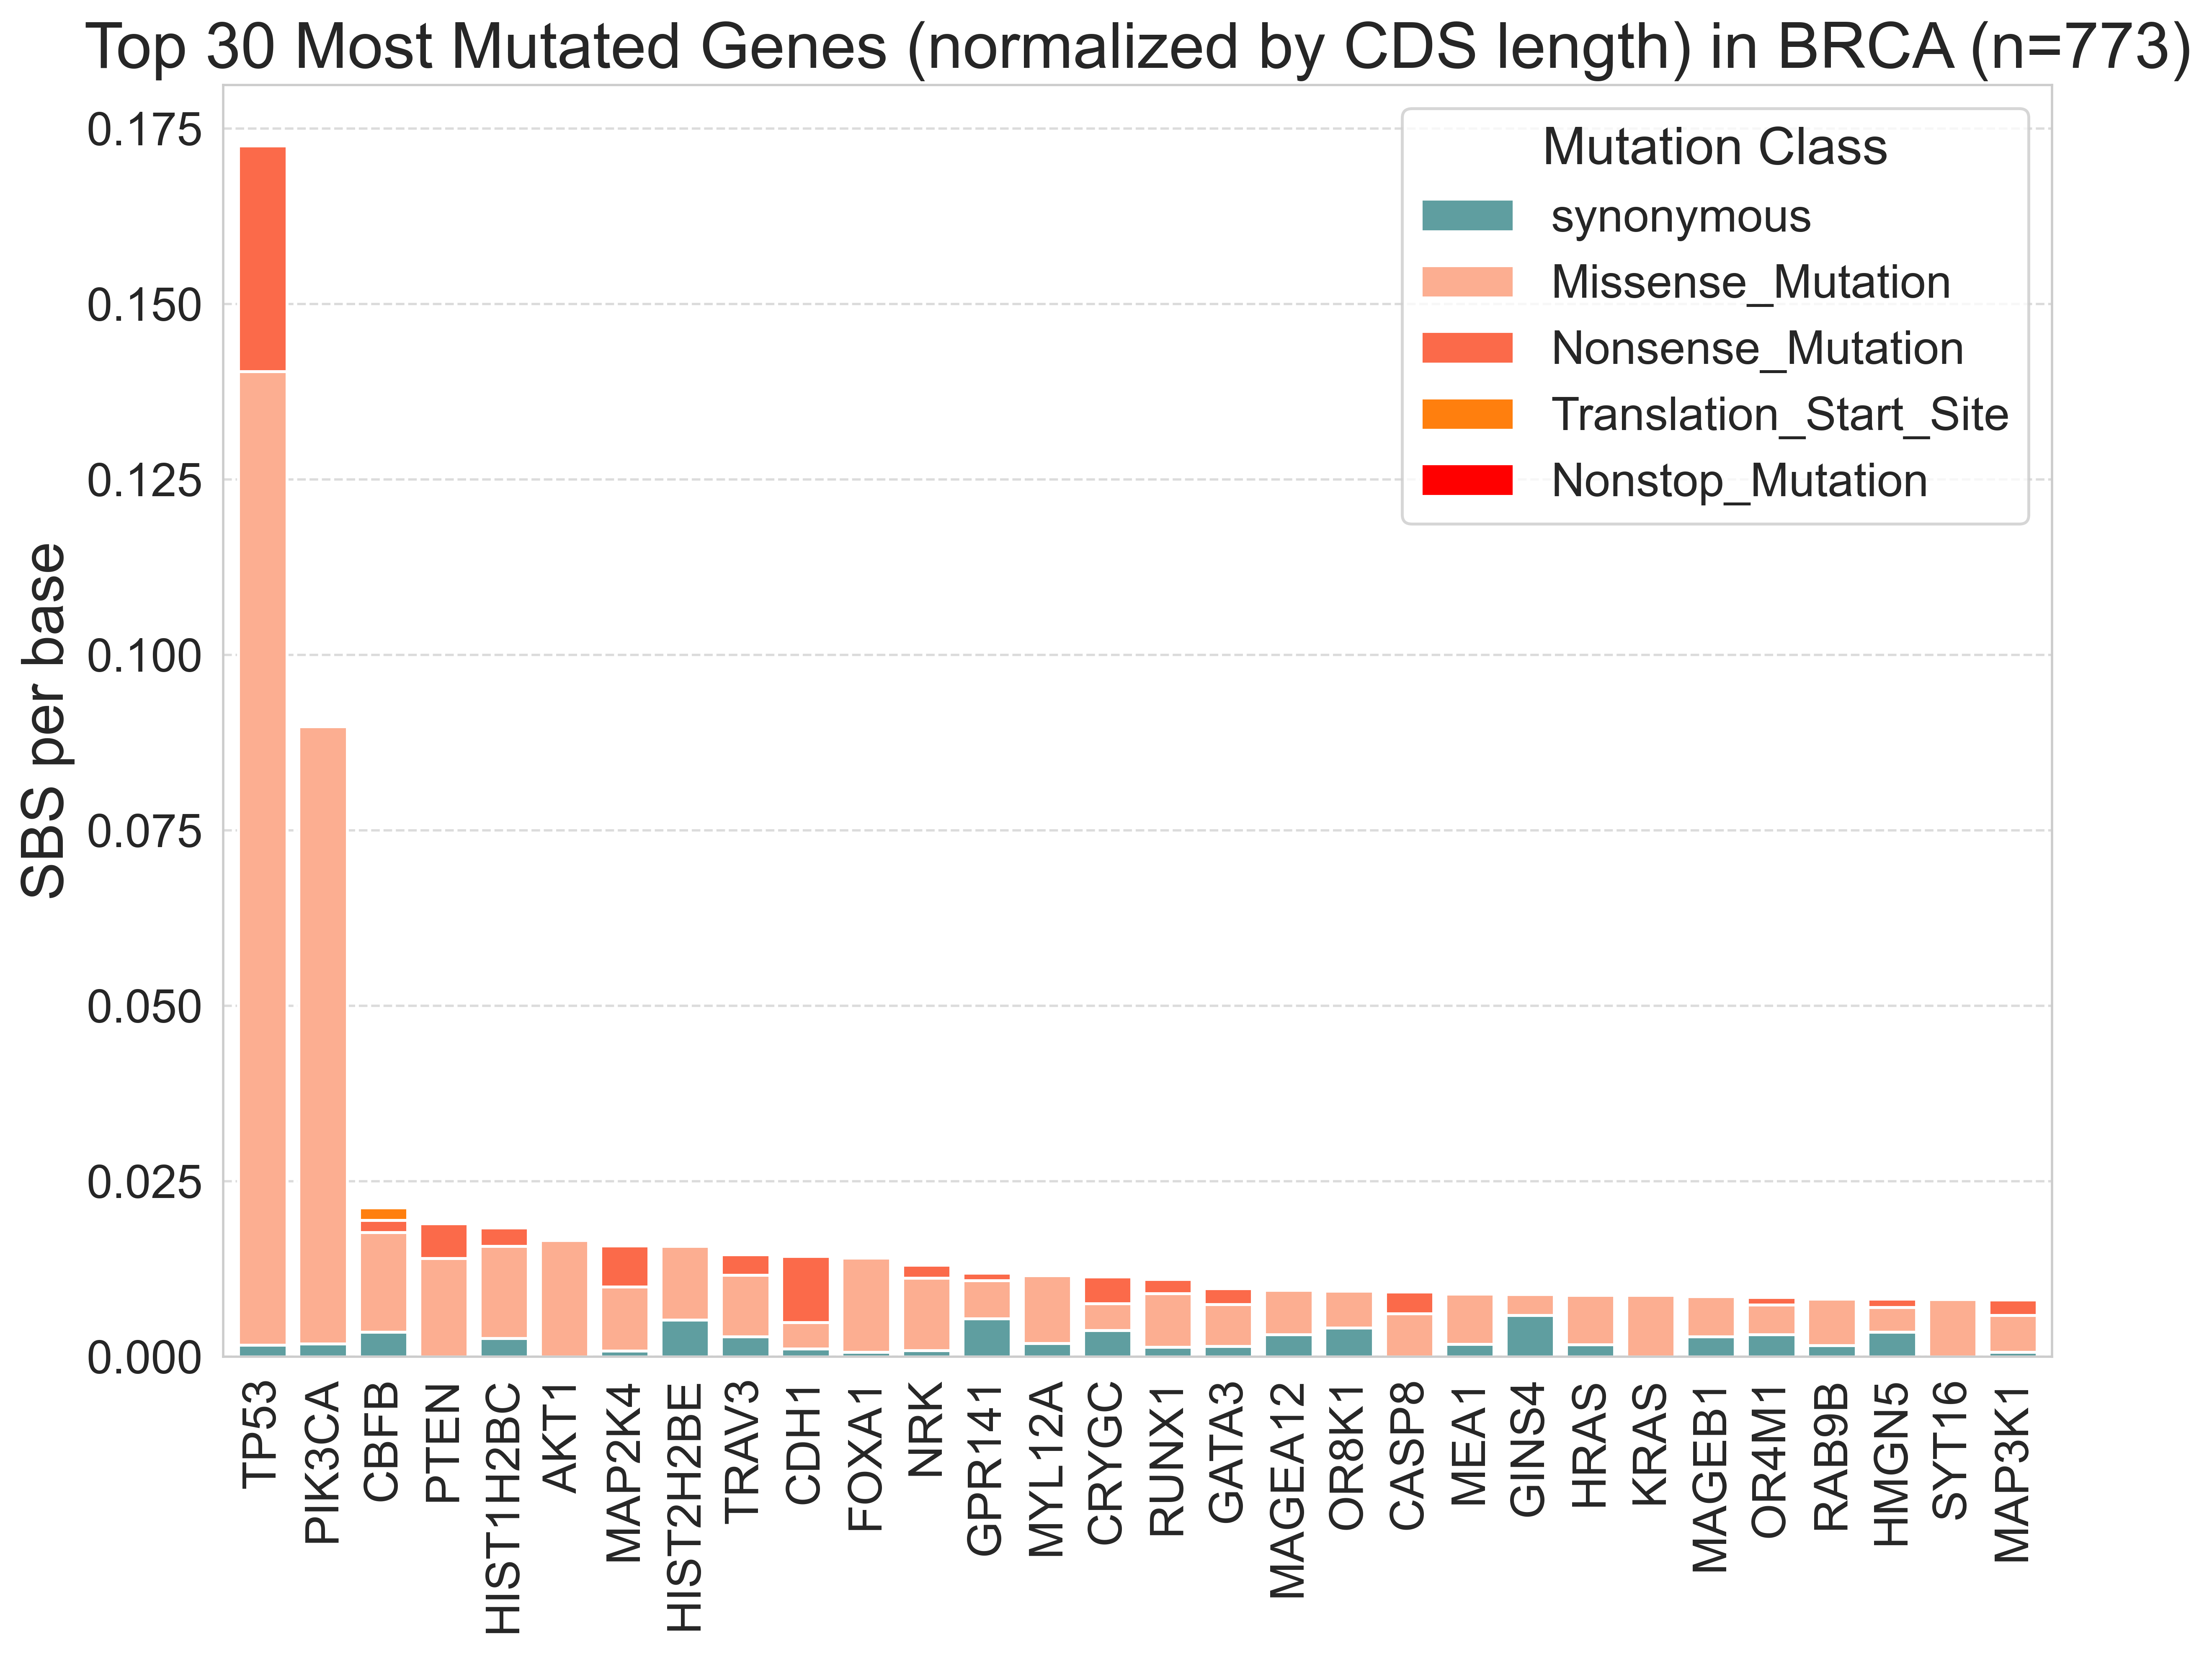

In [214]:
norm_df = counts_df[all_classes].div(counts_df['CDS_length'], axis=0).fillna(0)

# 8. Select top N genes by normalized total mutations
norm_df['Total'] = norm_df.sum(axis=1)
N = 30
plot_df = norm_df.sort_values('Total', ascending=False).head(N).drop(columns='Total')

# 9. Define color palette
palette = ['cadetblue', '#fcae91', '#fb6a4a', "tab:orange",  # Translation_Start_Site
    "red"]  # Nonstop_Mutation

# 10. Plot
if plot_df.empty:
    print("No data available to plot after filtering for ≥5 mutations.")
else:
    print(", ".join(list(plot_df.index)))
    fig, ax = plt.subplots(
        figsize=(max(10, len(plot_df) * 0.3), 8),
        dpi=500
    )

    # Plot on this axis
    plot_df.plot(
        kind='bar',
        stacked=True,
        width=0.8,
        color=palette,
        ax=ax
    )

    # Labels and styling
    ax.set_title(f'Top {N} Most Mutated Genes (normalized by CDS length) in BRCA (n=773)', fontsize=22)
    ax.set_xlabel('', fontsize=20)
    ax.set_ylabel('SBS per base', fontsize=20)
    ax.set_xticklabels(plot_df.index, rotation=90, fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.legend(title='Mutation Class', fontsize=16, title_fontsize=18)
    ax.grid(False)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()

    # Save at high resolution
    fig.savefig(
        "/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/results/figures/Most_mutated_genes_detailed_normalized.pdf",
        format="pdf",
        bbox_inches="tight",
        dpi=500
    )

    plt.show()

# Extract DNA sequence

In [173]:
df_sizes

,Transcript_ID,CDS_length
Hugo_Symbol,,
TTN,ENST00000589042,107976
MUC16,ENST00000397910,43524
OBSCN,ENST00000570156,26772
SYNE1,ENST00000367255,26394
NEB,ENST00000397345,25578
...,...,...
TRGJP,ENST00000390338,61
TRAJ50,ENST00000390487,60
TRAJ21,ENST00000390516,55


In [175]:
# 1. Parse FASTA into dict: base transcript ID (no version) -> (header, full sequence)
fasta_path = "/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/processed/gencode.v23lift37.pc_transcripts.transcripts_in_TCGA_MAF.fa"
transcripts = {}
with open(fasta_path, "r") as f:
    header = None
    seq_chunks = []
    for line in f:
        line = line.rstrip("\n")
        if line.startswith(">"):
            if header is not None:
                full_id = header[1:].split("|")[0]
                base_id = full_id.split(".")[0]
                transcripts[base_id] = (header, "".join(seq_chunks))
            header = line
            seq_chunks = []
        else:
            seq_chunks.append(line)
    # add last record
    if header is not None:
        full_id = header[1:].split("|")[0]
        base_id = full_id.split(".")[0]
        transcripts[base_id] = (header, "".join(seq_chunks))

# 2. Extract CDS sequences based on header coordinates and verify frame
cds_seqs = []
for gene, row in df_sizes.iterrows():
    tid = row["Transcript_ID"]
    if tid not in transcripts:
        print(f"Warning: transcript {tid} for gene {gene} not found in FASTA.")
        cds_seqs.append(None)
        continue

    header, full_seq = transcripts[tid]
    m = re.search(r"CDS:(\d+)-(\d+)", header)
    if not m:
        print(f"Warning: CDS coordinates not found in header for {tid}.")
        cds_seqs.append(None)
        continue

    start, end = map(int, m.groups())
    cds_seq = full_seq[start-1:end]  # 1-based inclusive
    if len(cds_seq) % 3 != 0:
        print(f"Warning: CDS sequence length for {tid} is {len(cds_seq)}, not a multiple of 3.")
    cds_seqs.append(cds_seq)

# 3. Append to df_sizes
df_sizes["CDS sequence"] = cds_seqs

In [176]:
df_sizes

,Transcript_ID,CDS_length,CDS sequence
Hugo_Symbol,,,
TTN,ENST00000589042,107976,ATGACAACTCAAGCACCGACGTTTACGCAGCCGTTACAAAGCGTTG...
MUC16,ENST00000397910,43524,ATGCTGAAACCCTCAGGCCTTCCTGGGTCATCTTCTCCCACCCGCT...
OBSCN,ENST00000570156,26772,ATGGATCAGCCACAGTTCAGCGGGGCGCCCCGCTTTCTCACCCGGC...
SYNE1,ENST00000367255,26394,ATGGCAACCTCCAGAGGGGCCTCCCGGTGTCCTCGGGATATCGCCA...
NEB,ENST00000397345,25578,ATGGCAGATGACGAAGACTATGAGGAGGTGGTGGAGTACTACACAG...
...,...,...,...
TRGJP,ENST00000390338,61,GGGCAAGAGTTGGGCAAAAAAATCAAGGTATTTGGTCCCGGAACAA...
TRAJ50,ENST00000390487,60,TGAAAACCTCCTACGACAAGGTGATATTTGGGCCAGGGACAAGCTT...
TRAJ21,ENST00000390516,55,TACAACTTCAACAAATTTTACTTTGGATCTGGGACCAAACTCAATG...


# Number of possible nonsynonymous and synonymous mutations per codon in each gene's CDS

In [177]:
def translate(seq): 
       
    table = { 
        'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M', 
        'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T', 
        'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K', 
        'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                  
        'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L', 
        'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P', 
        'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q', 
        'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R', 
        'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V', 
        'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A', 
        'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E', 
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G', 
        'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S', 
        'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L', 
        'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_', 
        'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W', 
    } 
    protein ="" 
    if len(seq)%3 == 0: 
        for i in range(0, len(seq), 3): 
            codon = seq[i:i + 3] 
            protein+= table[codon] 
    return protein 

In [178]:
bases = ['A', 'C', 'G', 'T']

syn_ops = []
nonsyn_ops = []

for gene, row in df_sizes.iterrows():
    seq = row["CDS sequence"]
    syn_count = 0
    nonsyn_count = 0

    if seq:
        if gene == "IGHJ5":
            print(f"Processing gene: {gene}")
            print(f"CDS sequence: {seq}")
            print(f"CDS length: {len(seq)}")
            print(range(0, len(seq) - 2, 3))
        # walk codons
        for i in range(0, len(seq) - 3 + 1, 3):

            codon = seq[i:i+3]
            ref_aa = translate(codon)

            if gene == "IGHJ5":
                print(codon, "->", ref_aa)
            # for each position in codon
            for pos in range(3):
                orig_base = codon[pos]
                for alt_base in bases:
                    if alt_base == orig_base:
                        continue
                    alt_codon = codon[:pos] + alt_base + codon[pos+1:]
                    aa = translate(alt_codon)
                    # Add at top of your script
                    bold_start = '\033[1m'
                    bold_end = '\033[0m'

                    # Then, inside your codon loop:
                    highlighted_codon = (
                        codon[:pos]
                        + bold_start + codon[pos] + bold_end
                        + codon[pos+1:]
                    )
                    highlighted_alt = (
                        alt_codon[:pos]
                        + bold_start + alt_codon[pos] + bold_end
                        + alt_codon[pos+1:]
                    )
                    if aa == ref_aa:
                        if gene == "IGHJ5":
                            print(f"{highlighted_codon}({ref_aa}) -> {highlighted_alt}({aa}) : S")
                        syn_count += 1
                    else:
                        if gene == "IGHJ5":
                            print(f"{highlighted_codon}({ref_aa}) -> {highlighted_alt}({aa}) : N")
                        nonsyn_count += 1

    syn_ops.append(syn_count)
    nonsyn_ops.append(nonsyn_count)

df_sizes["synonymous_opportunity"] = syn_ops
df_sizes["nonsynonymous_opportunity"] = nonsyn_ops

Processing gene: IGHJ5
CDS sequence: AACTGGTTCGACCCCTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG
CDS length: 49
range(0, 47, 3)
AAC -> N
AAC(N) -> CAC(H) : N
AAC(N) -> GAC(D) : N
AAC(N) -> TAC(Y) : N
AAC(N) -> ACC(T) : N
AAC(N) -> AGC(S) : N
AAC(N) -> ATC(I) : N
AAC(N) -> AAA(K) : N
AAC(N) -> AAG(K) : N
AAC(N) -> AAT(N) : S
TGG -> W
TGG(W) -> AGG(R) : N
TGG(W) -> CGG(R) : N
TGG(W) -> GGG(G) : N
TGG(W) -> TAG(_) : N
TGG(W) -> TCG(S) : N
TGG(W) -> TTG(L) : N
TGG(W) -> TGA(_) : N
TGG(W) -> TGC(C) : N
TGG(W) -> TGT(C) : N
TTC -> F
TTC(F) -> ATC(I) : N
TTC(F) -> CTC(L) : N
TTC(F) -> GTC(V) : N
TTC(F) -> TAC(Y) : N
TTC(F) -> TCC(S) : N
TTC(F) -> TGC(C) : N
TTC(F) -> TTA(L) : N
TTC(F) -> TTG(L) : N
TTC(F) -> TTT(F) : S
GAC -> D
GAC(D) -> AAC(N) : N
GAC(D) -> CAC(H) : N
GAC(D) -> TAC(Y) : N
GAC(D) -> GCC(A) : N
GAC(D) -> GGC(G) : N
GAC(D) -> GTC(V) : N
GAC(D) -> GAA(E) : N
GAC(D) -> GAG(E) : N
GAC(D) -> GAT(D) : S
CCC -> P
CCC(P) -> ACC(T) : N
CCC(P) -> GCC(A) : N
CCC(P) -> TCC(S) : N
CCC(P) -> CAC(H) :

In [179]:
df_sizes

,Transcript_ID,CDS_length,CDS sequence,synonymous_opportunity,nonsynonymous_opportunity
Hugo_Symbol,,,,,
TTN,ENST00000589042,107976,ATGACAACTCAAGCACCGACGTTTACGCAGCCGTTACAAAGCGTTG...,73976,249952
MUC16,ENST00000397910,43524,ATGCTGAAACCCTCAGGCCTTCCTGGGTCATCTTCTCCCACCCGCT...,33676,96896
OBSCN,ENST00000570156,26772,ATGGATCAGCCACAGTTCAGCGGGGCGCCCCGCTTTCTCACCCGGC...,19745,60571
SYNE1,ENST00000367255,26394,ATGGCAACCTCCAGAGGGGCCTCCCGGTGTCCTCGGGATATCGCCA...,16646,62536
NEB,ENST00000397345,25578,ATGGCAGATGACGAAGACTATGAGGAGGTGGTGGAGTACTACACAG...,15395,61339
...,...,...,...,...,...
TRGJP,ENST00000390338,61,GGGCAAGAGTTGGGCAAAAAAATCAAGGTATTTGGTCCCGGAACAA...,42,138
TRAJ50,ENST00000390487,60,TGAAAACCTCCTACGACAAGGTGATATTTGGGCCAGGGACAAGCTT...,38,142
TRAJ21,ENST00000390516,55,TACAACTTCAACAAATTTTACTTTGGATCTGGGACCAAACTCAATG...,32,130


# Calculate dN/dS

In [ ]:
# 1. Join observed counts with mutational opportunities
#    - counts_df: index=Hugo_Symbol, columns include 'synonymous', and various non-synonymous classes
#    - df_sizes: index=Hugo_Symbol, columns include 'synonymous_opportunity', 'nonsynonymous_opportunity'
df = counts_df.join(
    df_sizes[['synonymous_opportunity', 'nonsynonymous_opportunity']],
    how='inner'
)
df

,synonymous,Missense_Mutation,Nonsense_Mutation,Translation_Start_Site,Nonstop_Mutation,CDS_length,synonymous_opportunity,nonsynonymous_opportunity
Hugo_Symbol,,,,,,,,
A2M,1,4,2,0,0,4425.0,3082,10193
A2ML1,4,6,1,0,0,4365.0,3006,10089
AARS,1,4,0,0,0,2907.0,2014,6707
AATK,1,4,0,0,0,4125.0,3147,9228
ABCA1,2,3,0,0,0,6786.0,4612,15746
...,...,...,...,...,...,...,...,...
ZSCAN32,1,4,0,0,0,1458.0,919,3455
ZSWIM4,1,4,0,0,0,2970.0,2231,6679
ZSWIM8,3,6,0,0,0,5529.0,4116,12471


In [ ]:
# 2. Compute observed nonsynonymous as sum of all non-synonymous classes
nonsyn_cols = [
    "Missense_Mutation",
    "Nonsense_Mutation",
    "Translation_Start_Site",
    "Nonstop_Mutation"
]
df['observed_nonsynonymous'] = df[nonsyn_cols].sum(axis=1)

# 3. Calculate dS = observed_synonymous / synonymous_opportunity
df['dS'] = df['synonymous'] / df['synonymous_opportunity']

# 4. Calculate dN = observed_nonsynonymous / nonsynonymous_opportunity
df['dN'] = df['observed_nonsynonymous'] / df['nonsynonymous_opportunity']

# 5. Calculate dN/dS ratio
df['dN/dS'] = df['dN'] / df['dS']

df

,synonymous,Missense_Mutation,Nonsense_Mutation,Translation_Start_Site,Nonstop_Mutation,CDS_length,synonymous_opportunity,nonsynonymous_opportunity,observed_nonsynonymous,dS,dN,dN/dS
Hugo_Symbol,,,,,,,,,,,,
A2M,1,4,2,0,0,4425.0,3082,10193,6,0.000324,0.000589,1.814186
A2ML1,4,6,1,0,0,4365.0,3006,10089,7,0.001331,0.000694,0.521409
AARS,1,4,0,0,0,2907.0,2014,6707,4,0.000497,0.000596,1.201133
AATK,1,4,0,0,0,4125.0,3147,9228,4,0.000318,0.000433,1.364109
ABCA1,2,3,0,0,0,6786.0,4612,15746,3,0.000434,0.000191,0.439350
...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN32,1,4,0,0,0,1458.0,919,3455,4,0.001088,0.001158,1.063965
ZSWIM4,1,4,0,0,0,2970.0,2231,6679,4,0.000448,0.000599,1.336128
ZSWIM8,3,6,0,0,0,5529.0,4116,12471,6,0.000729,0.000481,0.660091


# Drop infinite (no observed synonymous) and NA (no observed nonsynonymous)

In [188]:
import numpy as np
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['dN/dS'])

In [189]:
df.sort_values('dN/dS', ascending=False).head(30)

,synonymous,Missense_Mutation,Nonsense_Mutation,Translation_Start_Site,Nonstop_Mutation,CDS_length,synonymous_opportunity,nonsynonymous_opportunity,observed_nonsynonymous,dS,dN,dN/dS
Hugo_Symbol,,,,,,,,,,,,
TP53,2,164,38,0,0,1182.0,831,2715,202,0.002407,0.074401,30.913812
PIK3CA,6,282,0,0,0,3207.0,2005,7616,282,0.002993,0.037027,12.373293
LRP2,1,24,0,0,0,13968.0,8782,33122,24,0.000114,0.000725,6.363384
FOXA1,1,19,0,0,0,1419.0,1014,3243,19,0.000986,0.005859,5.940796
MAP2K4,1,11,7,0,0,1200.0,785,2815,18,0.001274,0.006394,5.019538
ATP10B,1,14,2,0,0,4386.0,2961,10197,16,0.000338,0.001569,4.646072
ARID1A,1,5,10,0,0,6858.0,4862,15712,15,0.000206,0.000955,4.641675
AKAP9,1,16,2,0,0,11724.0,7036,28136,18,0.000142,0.000640,4.501279
FAM135B,1,12,2,0,0,4221.0,2923,9740,14,0.000342,0.001437,4.201437


In [ ]:
# An example
df.loc[["TRIM9"]]

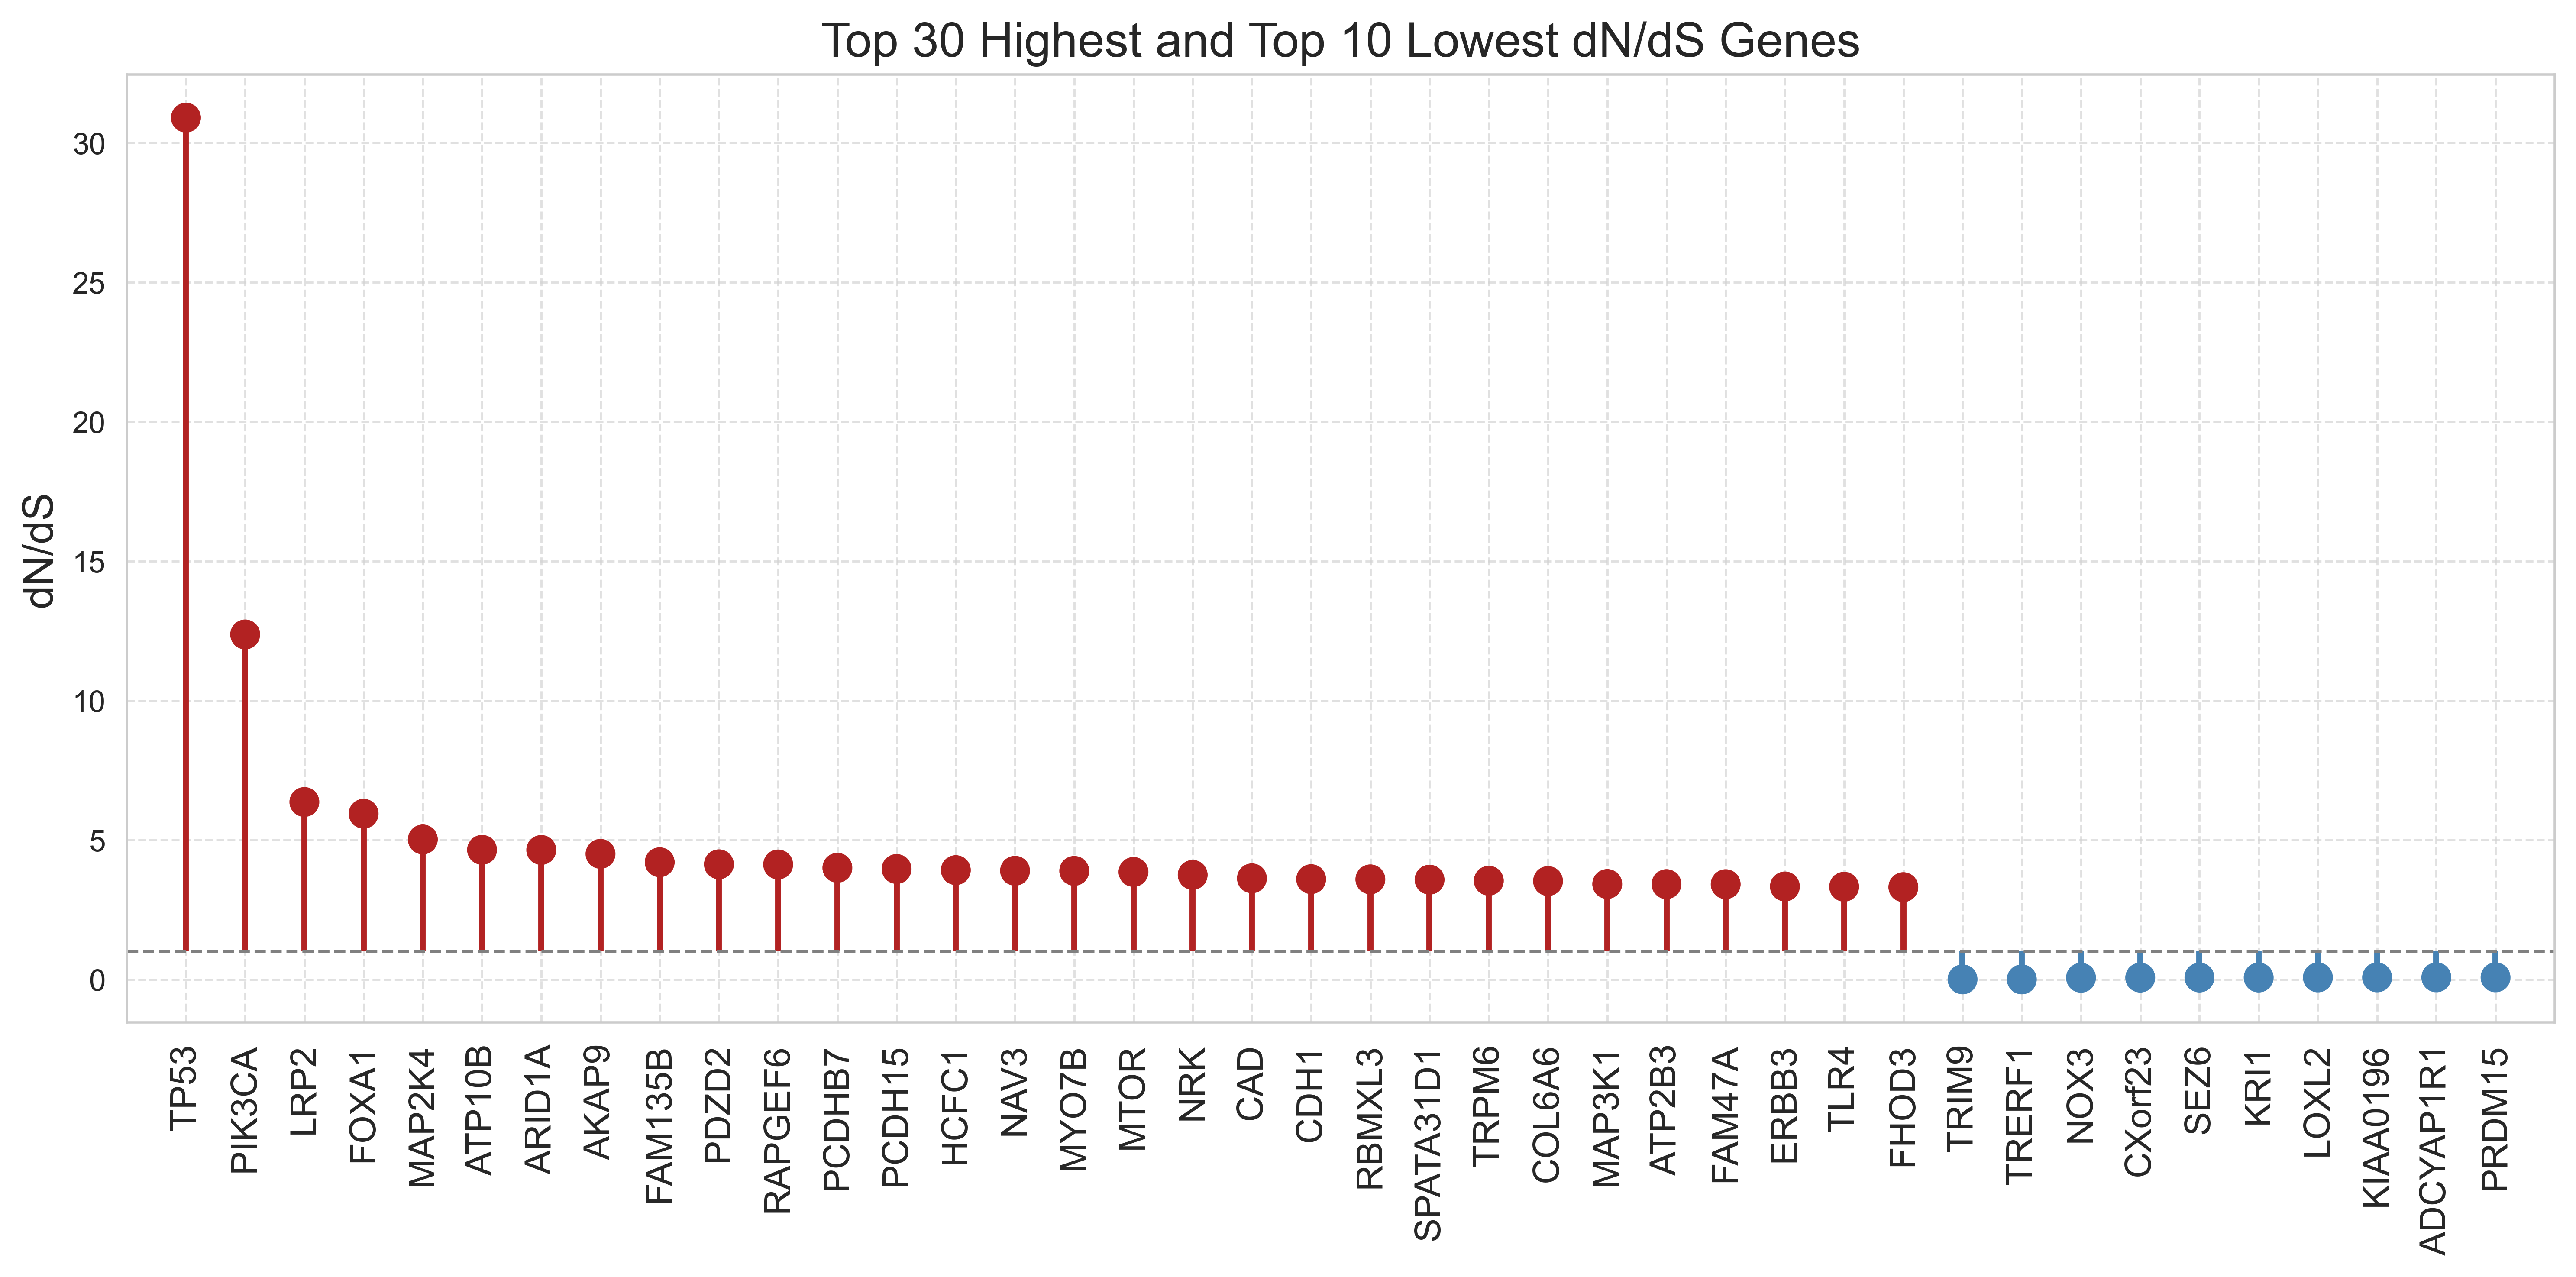

In [212]:
# 1. Sort to get top 30 highest and top 10 lowest dN/dS
df_high = df.sort_values('dN/dS', ascending=False).head(30)
df_low  = df.sort_values('dN/dS', ascending=True).head(10)

# 2. Combine into one DataFrame
df_plot = pd.concat([df_high, df_low])[['dN/dS']]
df_plot = df_plot.reset_index().rename(columns={'index': 'Hugo_Symbol'})

# 3. Prepare x positions, y values, and colors
x = np.arange(len(df_plot))
y = df_plot['dN/dS'].values
colors = ['firebrick'] * len(df_high) + ['steelblue'] * len(df_low)

# 4. Create lollipop plot
fig, ax = plt.subplots(figsize=(max(12, len(df_plot)*0.3), 6), dpi=500)
for xi, yi, c in zip(x, y, colors):
    # Draw stem from baseline y=1 to the point
    ax.vlines(xi, 1, yi, color=c, linewidth=2)
# Draw dots on top of stems
ax.scatter(x, y, c=colors, s=80, zorder=3)

# 5. Baseline at y=1
ax.axhline(1, color='gray', linestyle='--', linewidth=1)

# 6. Adjust x-axis and reduce margins
ax.set_xlim(-1, len(df_plot))
ax.set_xticks(x)
ax.set_xticklabels(df_plot['Hugo_Symbol'], rotation=90, fontsize=12)
ax.set_ylabel('dN/dS', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7, linewidth=0.7, color="lightgray")
plt.grid(axis='y', linestyle='--', alpha=0.7, linewidth=0.7, color="lightgray")
plt.title('Top 30 Highest and Top 10 Lowest dN/dS Genes', fontsize=16)
plt.tight_layout()

# 7. Save and show
output_path = "/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/results/figures/dNdS_lolliplot_top30_bottom10.pdf"
plt.savefig(output_path, format="pdf", bbox_inches="tight")
plt.show()

In [224]:
df_intogen_sorted

,Symbol,Mutations,Samples,Samples (%)
0,PIK3CA,383,335,33.20
1,TP53,349,299,29.63
5,MAP3K1,128,79,7.83
2,CDH1,127,97,9.61
3,GATA3,125,97,9.61
4,KMT2C,109,85,8.42
6,PTEN,56,43,4.26
8,NCOR1,50,40,3.96
9,RUNX1,45,36,3.57
10,MAP2K4,44,33,3.27


Top 30 genes by dN/dS: TP53, PIK3CA, LRP2, FOXA1, MAP2K4, ATP10B, ARID1A, AKAP9, FAM135B, PDZD2, RAPGEF6, PCDHB7, PCDH15, HCFC1, NAV3, MYO7B, MTOR, NRK, CAD, CDH1, RBMXL3, SPATA31D1, TRPM6, COL6A6, MAP3K1, ATP2B3, FAM47A, ERBB3, TLR4, FHOD3


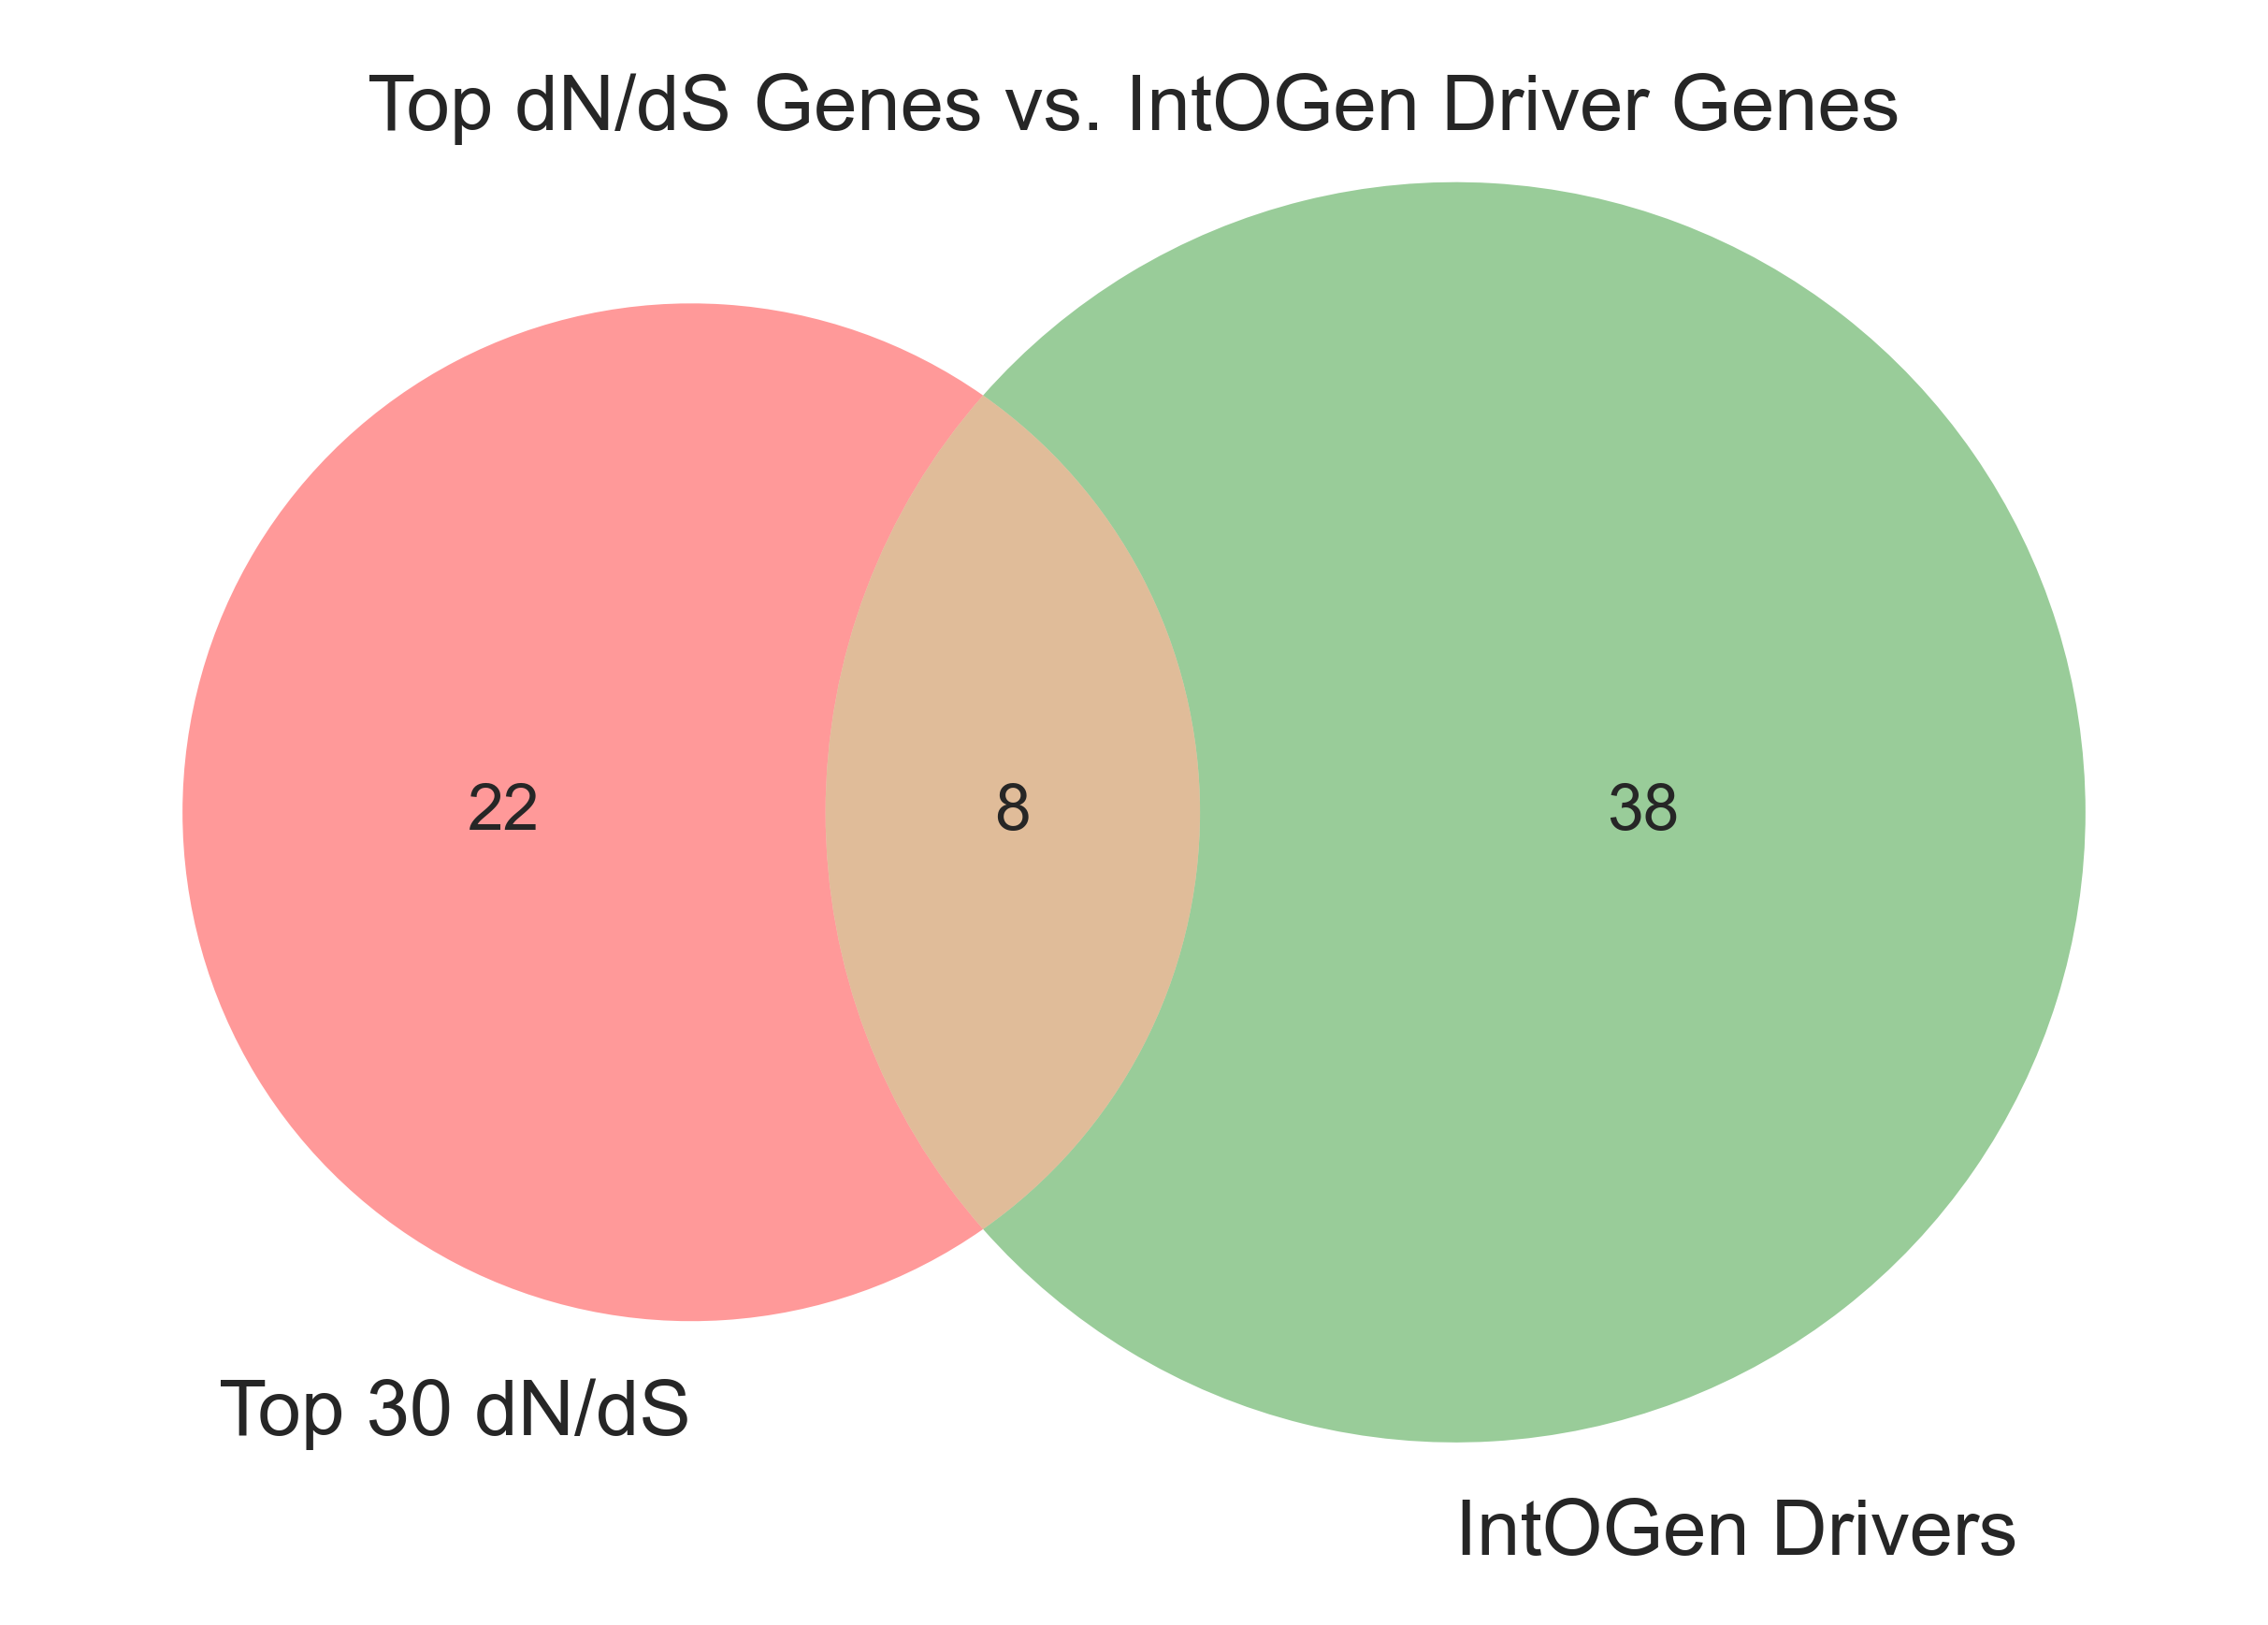

In [223]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# 1. Sort by dN/dS and take top 30 genes
top30_genes = df.sort_values('dN/dS', ascending=False).head(30).index.tolist()
string=", ".join(top30_genes)
print("Top 30 genes by dN/dS:" , string)

# 2. Get IntOGen driver gene symbols
intogen_genes = df_intogen_sorted['Symbol'].tolist()

# 3. Convert to sets
set_top30 = set(top30_genes)
set_intogen = set(intogen_genes)

# 4. Plot Venn diagram
plt.figure(figsize=(6,6), dpi=500)
venn2([set_top30, set_intogen],
      set_labels=('Top 30 dN/dS', 'IntOGen Drivers'))
plt.title('Top dN/dS Genes vs. IntOGen Driver Genes', y=0.92)
plt.show()